In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [77]:
sen_attr_dict = {
    'adult': 'sex',
    'compas': 'sex',
    'bank': 'age',
    'retiring_adult': 'race',
    'retiring_adult_coverage': 'race'
}

In [78]:
dataset = 'adult'
sen_attr = sen_attr_dict[dataset]
option = 'fair_with_val_loss' # 'fair_only', 'intersect'
constraint = 'eopp'
alpha_arr = np.arange(0.1, 1.1, 0.1)
if dataset == "compas":
    k_arr = np.arange(1, 21, 1)
else:
    k_arr = np.concatenate((np.arange(0.1, 1, 0.1), np.arange(1, 21, 1)))
#     k_arr = np.concatenate((np.arange(0.1, 1.1, 0.1), np.arange(1, 3, 1)))
#k_arr = np.arange(0.1, 1.1, 0.1) # np.arange(0.1, 1.1, 0.1) or np.arange(1, 21, 1)
#k_arr = np.arange(1, 21, 1)
seed_arr = [0, 1, 2, 3, 4]
# seed_arr = [0]

In [79]:
# # naive

# trng_acc_list = np.array([])
# trng_fair_list = np.array([])

# val_acc_list = np.array([])
# val_fair_list = np.array([])

# test_acc_list = np.array([])
# test_fair_list = np.array([])

# if constraint == "eopp":
#     filename = "./log/fair_only/{}_eopp_seed_{}_sen_attr_{}_naive_log.txt"
# elif constraint == "eo":
#     filename = "./log/fair_only/{}_eo_seed_{}_sen_attr_{}_naive_log.txt"

# for seed in seed_arr:
#     with open(filename.format(dataset, seed, sen_attr), "rb") as fp:
#         log = pickle.load(fp)
#         max_idx = np.argmax(np.array(log[0]))
        
#         trng_acc_list = np.append(trng_acc_list, log[0][max_idx])
#         trng_fair_list = np.append(trng_fair_list, log[1][max_idx])
#         val_acc_list = np.append(val_acc_list, log[2][max_idx])
#         val_fair_list = np.append(val_fair_list, log[3][max_idx])
#         test_acc_list = np.append(test_acc_list, log[4][max_idx])
#         test_fair_list = np.append(test_fair_list, log[5][max_idx])
        
# naive_trng_acc = np.mean(trng_acc_list)
# naive_trng_fair = np.mean(trng_fair_list)
# naive_val_acc = np.mean(val_acc_list)
# naive_val_fair = np.mean(val_fair_list)
# naive_test_acc = np.mean(test_acc_list)
# naive_test_fair = np.mean(test_fair_list)
        
# print(f"Average Trng Acc: {np.mean(trng_acc_list)}, Average Trng Fair: {np.mean(trng_fair_list)}")
# print(f"Average Val Acc: {np.mean(val_acc_list)}, Average Val Fair: {np.mean(val_fair_list)}")
# print(f"Average Test Acc: {np.mean(test_acc_list)}, Average Test Fair: {np.mean(test_fair_list)}")
    

In [80]:
# Top k Last Epoch

'''
log[0]: trng acc
log[1]: trng fair
log[2]: val acc
log[3]: val fair
log[4]: test acc
log[5]: test fair
'''

val_acc_log = np.zeros((len(seed_arr), len(k_arr), len(alpha_arr)))
val_fair_log = np.zeros((len(seed_arr), len(k_arr), len(alpha_arr)))
test_acc_log = np.zeros((len(seed_arr), len(k_arr), len(alpha_arr)))
test_fair_log = np.zeros((len(seed_arr), len(k_arr), len(alpha_arr)))


epoch = 50
if constraint == "eopp":
    filename = "./log/{}/{}_eopp_seed_{}_k_{:.1f}_alpha_{:.1f}_sen_attr_{}_acc_fair_log.txt"
elif constraint == "eo":
    filename = "./log/{}/{}_eo_seed_{}_k_{:.1f}_alpha_{:.1f}_sen_attr_{}_acc_fair_log.txt"

for seed_idx, seed in enumerate(seed_arr):
    for k_idx, k in enumerate(k_arr):
        for alpha_idx, alpha in enumerate(alpha_arr):
            with open(filename.format(option, dataset, seed, k, alpha, sen_attr), "rb") as fp:
                log = pickle.load(fp)
                val_acc_log[seed_idx, k_idx, alpha_idx] = log[2][epoch - 1]
                val_fair_log[seed_idx, k_idx, alpha_idx] = log[3][epoch - 1]
                test_acc_log[seed_idx, k_idx, alpha_idx] = log[4][epoch - 1]
                test_fair_log[seed_idx, k_idx, alpha_idx] = log[5][epoch - 1]

# print(f"Average Trng Acc: {np.mean(trng_acc_list)}, Average Trng Fair: {np.mean(trng_fair_list)}")
# print(f"Average Val Acc: {np.mean(val_acc_list)}, Average Val Fair: {np.mean(val_fair_list)}")
# print(f"Average Test Acc: {np.mean(test_acc_list)}, Average Test Fair: {np.mean(test_fair_list)}")

val_acc_log = np.mean(val_acc_log, axis=0)
val_fair_log = np.mean(val_fair_log, axis=0)
test_acc_log = np.mean(test_acc_log, axis=0)
test_fair_log = np.mean(test_fair_log, axis=0)


(9, 3) (4, 5)
0.0038170958269241996 0.8491321325302124


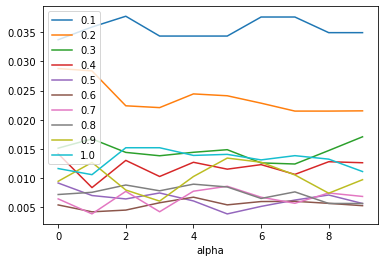

In [81]:
for k_idx, k in enumerate(k_arr):
    if k_idx < 10:
        plt.plot(test_fair_log[k_idx], label="{:.1f}".format(k))
    

plt.xlabel("alpha")
plt.legend()


argmin_val = np.unravel_index(val_fair_log.argmin(), val_fair_log.shape)
argmin_test = np.unravel_index(test_fair_log.argmin(), test_fair_log.shape)

print(argmin_val, argmin_test)
print(test_fair_log[argmin_test], test_acc_log[argmin_test])


In [82]:
# Top k group wise accuracy

# (epoch, trng/val/test, group, 2by2 confusion)

val_tpr_g0 = np.zeros((len(k_arr), len(alpha_arr)))
val_tpr_g1 = np.zeros((len(k_arr), len(alpha_arr)))
test_tpr_g0 = np.zeros((len(k_arr), len(alpha_arr)))
test_tpr_g1 = np.zeros((len(k_arr), len(alpha_arr)))

val_tnr_g0 = np.zeros((len(k_arr), len(alpha_arr)))
val_tnr_g1 = np.zeros((len(k_arr), len(alpha_arr)))
test_tnr_g0 = np.zeros((len(k_arr), len(alpha_arr)))
test_tnr_g1 = np.zeros((len(k_arr), len(alpha_arr)))

if constraint == "eopp":
    filename = "./log/{}/{}_eopp_seed_{}_k_{:.1f}_alpha_{:.1f}_sen_attr_{}_confusion_matrix.txt"
elif constraint == "eo":
    filename = "./log/{}/{}_eo_seed_{}_k_{:.1f}_alpha_{:.1f}_sen_attr_{}_confusion_matrix.txt"

    
for k_idx, k in enumerate(k_arr):
    for alpha_idx, alpha in enumerate(alpha_arr):
        val_g0 = np.zeros((2, 2))
        val_g1 = np.zeros((2,2))
        test_g0 = np.zeros((2,2))
        test_g1 = np.zeros((2,2))
        for seed_idx, seed in enumerate(seed_arr):
            with open(filename.format(option, dataset, seed, k, alpha, sen_attr), "rb") as fp:
                log = pickle.load(fp)[50 - 1]

                for g in range(2):
                    if g == 0:
                        val_g0 += log[1][g]
                        test_g0 += log[2][g]
                    elif g == 1:
                        val_g1 += log[1][g]
                        test_g1 += log[2][g]
        
        val_g0 /= len(seed_arr)
        val_g1 /= len(seed_arr)
        test_g0 /= len(seed_arr)
        test_g1 /= len(seed_arr)
        
        val_tpr_g0[k_idx, alpha_idx] = val_g0[1][1]/(val_g0[1][0]+val_g0[1][1])
        val_tpr_g1[k_idx, alpha_idx] = val_g1[1][1]/(val_g1[1][0]+val_g1[1][1])
        test_tpr_g0[k_idx, alpha_idx] = test_g0[1][1]/(test_g0[1][0]+test_g0[1][1])
        test_tpr_g1[k_idx, alpha_idx] = test_g1[1][1]/(test_g1[1][0]+test_g1[1][1])
        
        val_tnr_g0[k_idx, alpha_idx] = val_g0[0][0]/(val_g0[0][0]+val_g0[0][1])
        val_tnr_g1[k_idx, alpha_idx] = val_g1[0][0]/(val_g1[0][0]+val_g1[0][1])
        test_tnr_g0[k_idx, alpha_idx] = test_g0[0][0]/(test_g0[0][0]+test_g0[0][1])
        test_tnr_g1[k_idx, alpha_idx] = test_g1[0][0]/(test_g1[0][0]+test_g1[0][1])


            
    
    
# for k in k_arr:
#     for alpha in alpha_arr:
#         val_g0 = np.zeros((2,2))
#         val_g1 = np.zeros((2,2))
#         test_g0 = np.zeros((2,2))
#         test_g1 = np.zeros((2,2))
#         for seed in seed_arr:
#             with open(filename.format(option, dataset, seed, k, sen_attr), "rb") as fp:
#                 log = pickle.load(fp)[50 - 1]

#                 for g in range(2):
#                     if g == 0:
#                         val_g0 += log[1][g]
#                         test_g0 += log[2][g]
#                     elif g == 1:
#                         val_g1 += log[1][g]
#                         test_g1 += log[2][g]


#         val_g0 /= len(seed_arr)
#         val_g1 /= len(seed_arr)
#         test_g0 /= len(seed_arr)
#         test_g1 /= len(seed_arr)



#         print(f"g0, {k}:", test_g0)
#     #     print(f"g1, {k}:", test_g1)
#         val_tpr_g0_by_k = np.append(val_tpr_g0_by_k, val_g0[1][1]/(val_g0[1][0]+val_g0[1][1]))
#         val_tpr_g1_by_k = np.append(val_tpr_g1_by_k, val_g1[1][1]/(val_g1[1][0]+val_g1[1][1]))
#         test_tpr_g0_by_k = np.append(test_tpr_g0_by_k, test_g0[1][1]/(test_g0[1][0]+test_g0[1][1]))
#         test_tpr_g1_by_k = np.append(test_tpr_g1_by_k, test_g1[1][1]/(test_g1[1][0]+test_g1[1][1]))

#         val_tnr_g0_by_k = np.append(val_tnr_g0_by_k, val_g0[0][0]/(val_g0[0][0]+val_g0[0][1]))
#         val_tnr_g1_by_k = np.append(val_tnr_g1_by_k, val_g1[0][0]/(val_g1[0][0]+val_g1[0][1]))
#         test_tnr_g0_by_k = np.append(test_tnr_g0_by_k, test_g0[0][0]/(test_g0[0][0]+test_g0[0][1]))
#         test_tnr_g1_by_k = np.append(test_tnr_g1_by_k, test_g1[0][0]/(test_g1[0][0]+test_g1[0][1]))


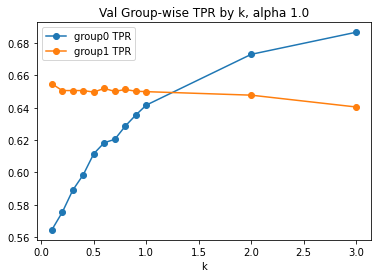

In [96]:
alpha_idx = 9

plt.plot(k_arr[:12], val_tpr_g0[:12, alpha_idx], 'o-', label="group0 TPR")
plt.plot(k_arr[:12], val_tpr_g1[:12, alpha_idx], 'o-', label="group1 TPR")

plt.legend()
plt.title("Val Group-wise TPR by k, alpha {}".format(alpha_arr[alpha_idx]))
plt.xlabel("k")
plt.show()

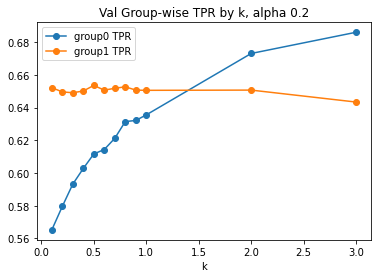

In [95]:
alpha_idx = 1

plt.plot(k_arr[:12], val_tpr_g0[:12, alpha_idx], 'o-', label="group0 TPR")
plt.plot(k_arr[:12], val_tpr_g1[:12, alpha_idx], 'o-', label="group1 TPR")

plt.legend()
plt.title("Val Group-wise TPR by k, alpha {}".format(alpha_arr[alpha_idx]))
plt.xlabel("k")
plt.show()

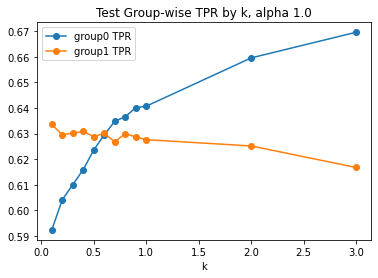

In [98]:
alpha_idx = 9

plt.plot(k_arr[:12], test_tpr_g0[:12, alpha_idx], 'o-', label="group0 TPR")
plt.plot(k_arr[:12], test_tpr_g1[:12, alpha_idx], 'o-', label="group1 TPR")

plt.legend()
plt.title("Test Group-wise TPR by k, alpha {}".format(alpha_arr[alpha_idx]))
plt.xlabel("k")
plt.show()


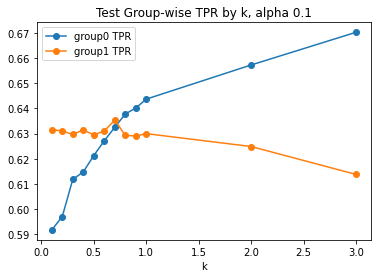

In [100]:
alpha_idx = 0

plt.plot(k_arr[:12], test_tpr_g0[:12, alpha_idx], 'o-', label="group0 TPR")
plt.plot(k_arr[:12], test_tpr_g1[:12, alpha_idx], 'o-', label="group1 TPR")

plt.legend()
plt.title("Test Group-wise TPR by k, alpha {}".format(alpha_arr[alpha_idx]))
plt.xlabel("k")
plt.show()